#### Import Library

In [2]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Generating Random Numbers

In [3]:
# Lagged Fibonacci Generator
def lfg(n = 1, mu = 31, nu = 97, seed = 104729, a = 1664525, b = 1013904223, M = 2**32):
    
    U = np.zeros(n, dtype = float)
    U[0] = seed

    # Perform standard LCG generate number up to nu
    for i in range(1, nu):
        U[i] = (a * U[i - 1] + b) % M
    
    # Perform Fibonacci operation
    for i in range(nu, n):
        U[i] = (U[i - nu] - U[i - mu]) % M
    
    return U / M

# Generate random N(0,1) using Box-Muller Transformation
def rnorm(n = 1, seed = 104729):
    # Generate random U(0,1) of length 2n to break down to indepdennt U1 and U2
    U = lfg(n * 2, seed = seed)
    U1, U2 = U[0::2], U[1::2]

    # Perform Box-Muller transformation
    return np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)


#### Checking Quality of Random Numbers

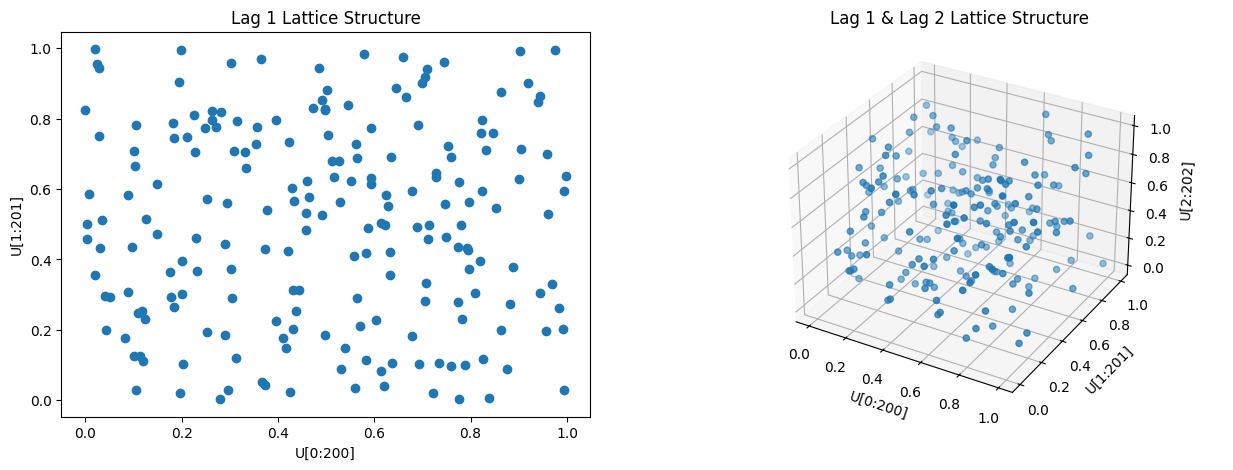

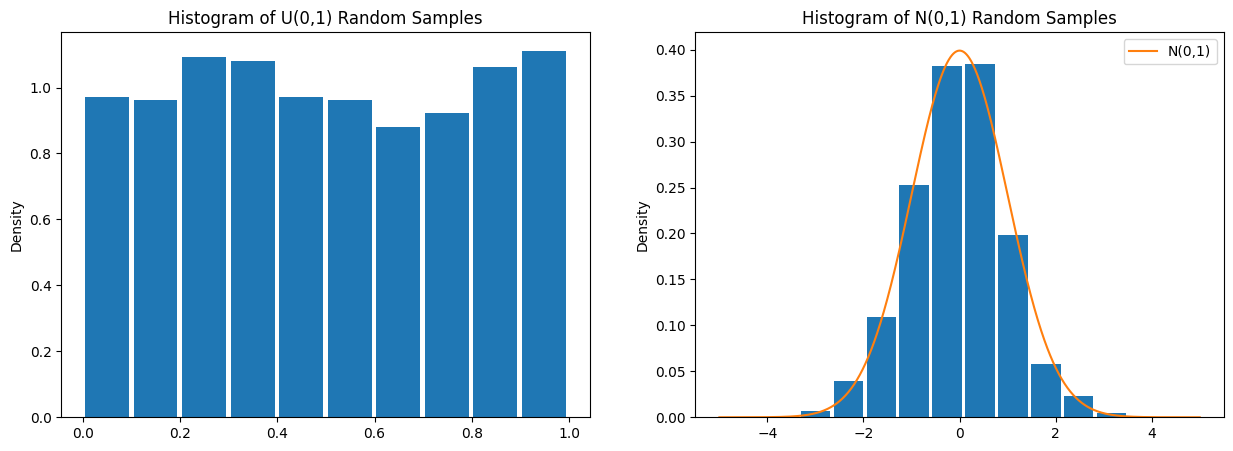

In [4]:
# RNG Checking

U = lfg(1000)
Z = rnorm(1000)

# Lattice Structure ===========================================================
U0, U1, U2 = U[0:200], U[1:201], U[2:202]
fig, ax = plt.subplots(1, 2, figsize = (15, 5), clear = True)

ax[0].set_title("Lag 1 Lattice Structure")
ax[0].scatter(U0, U1)

ax[0].set_xlabel('U[0:200]')
ax[0].set_ylabel('U[1:201]')

ax[1].axis('off')
ax[1] = fig.add_subplot(122, projection = '3d')
ax[1].set_title("Lag 1 & Lag 2 Lattice Structure")
ax[1].scatter(U0, U1, U2)

ax[1].set_xlabel('U[0:200]')
ax[1].set_ylabel('U[1:201]')
ax[1].set_zlabel('U[2:202]')

plt.show()

# Histograms ==================================================================
# U(0,1)
fig, ax = plt.subplots(1, 2, figsize = (15, 5), clear = True)

ax[0].hist(U, density = True, rwidth = 0.9)
ax[0].set_title("Histogram of U(0,1) Random Samples")
ax[0].set_ylabel("Density")

# N(0,1)
ax[1].hist(Z, density = True, rwidth = 0.9)
ax[1].set_title("Histogram of N(0,1) Random Samples")
ax[1].set_ylabel("Density")

x = np.linspace(-5, 5, 1000)
y = stats.norm.pdf(x)
ax[1].plot(x, y)
ax[1].legend(["N(0,1)"])

plt.show()

del U, Z

## Stochastic Process Simulations

#### Grometric Brownian Motion

$$
dX_t = \mu S_t dt + \sigma S_t dW_t\qquad\implies\qquad S_{t+\Delta t} = S_t\exp\left((\mu - \frac{1}{2}\sigma^2)\Delta t+\sigma\sqrt{\Delta t}Z \right)
$$

**Statistics**

$$
\begin{aligned}
\mathbb{E}[X_t] &= X_0\exp\left(\mu t \right) \\ \\
\mathbb{V}[X_t] &= \underset{=\mathbb{E}[X^2]}{X_0^2\exp\left( 2t(\mu-\frac{1}{2}\sigma^2)+2\sigma^2t \right)} - \mathbb{E}[X_t]^2
\end{aligned}
$$

**Theoretical PDF at Time $t$**

```python
stats.lognorm.pdf(x, s=sigma*np.sqrt(t), scale=np.exp(mu*t))
```

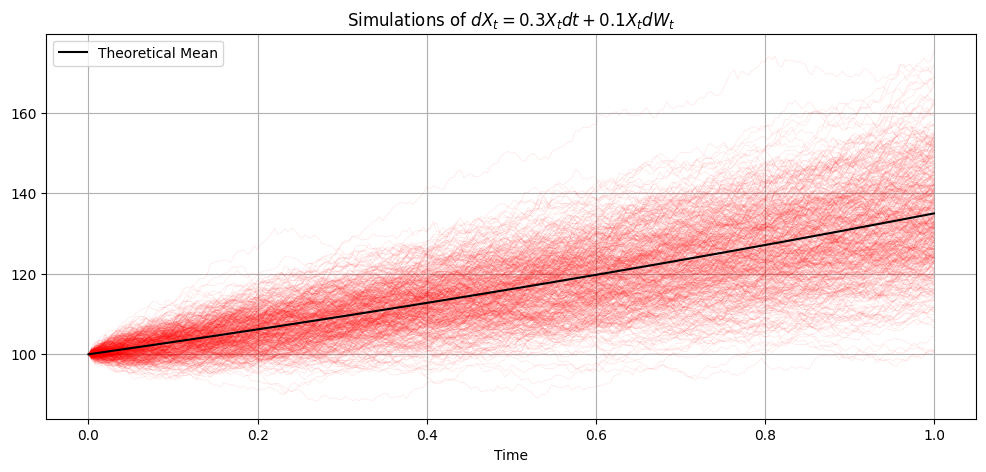

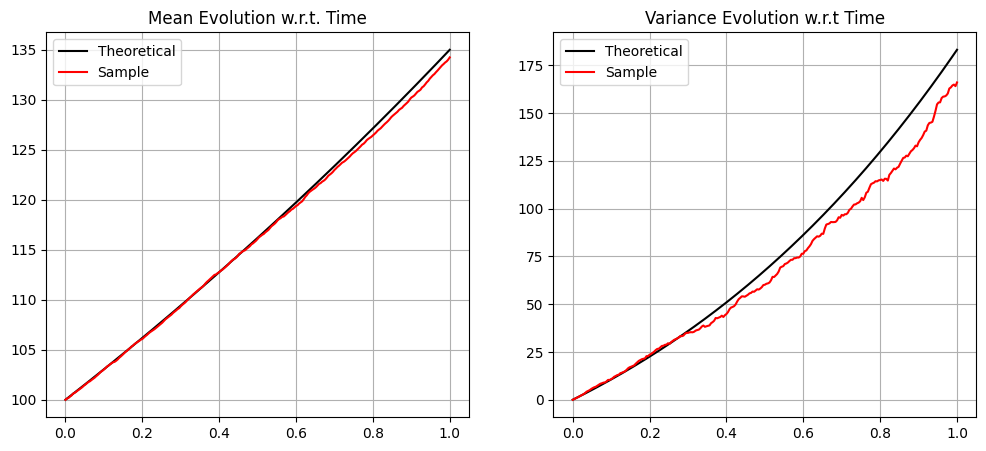

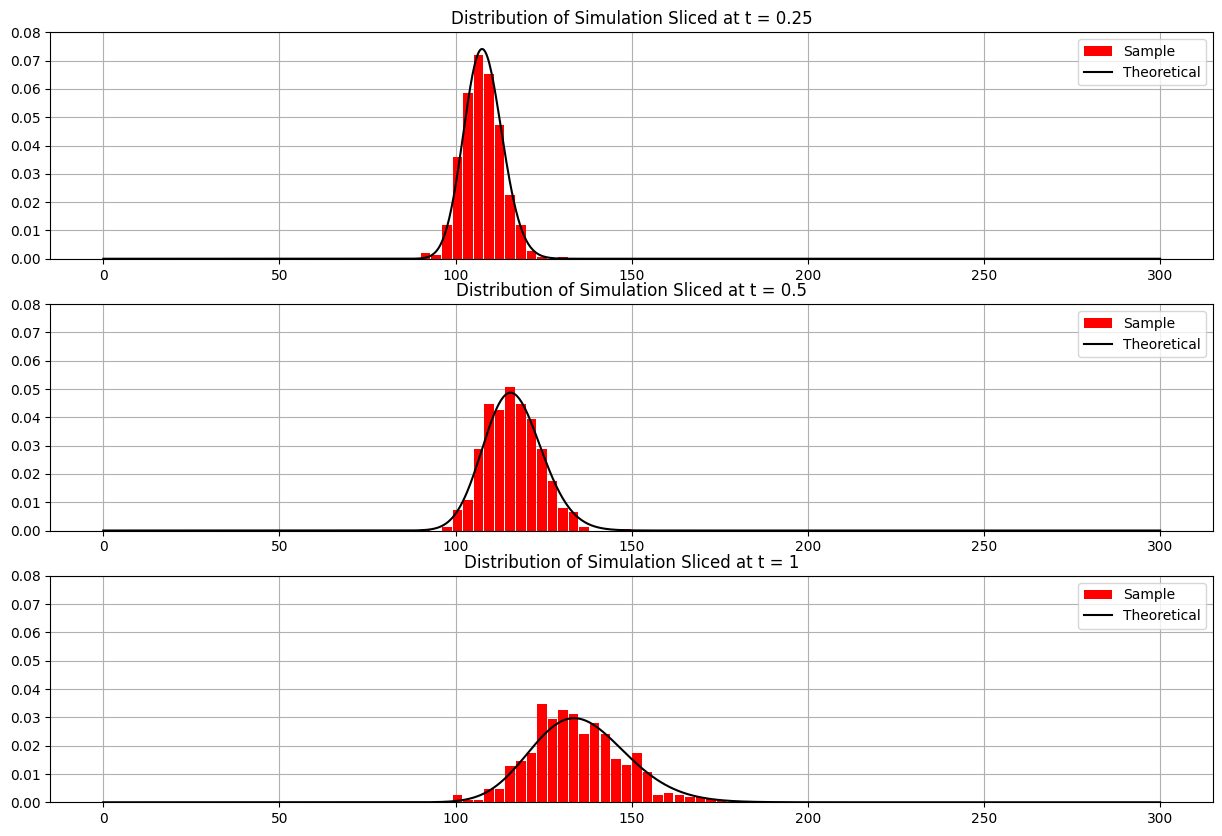

In [5]:
# GBM parameters
N_SIMS = 500    # FIXME: number of simulations
N_STEPS = 250   # FIXME: number of steps (excluding t = 0)
MU = 0.3        # FIXME: drift
SIGMA = 0.1     # FIXME: volatility
X0 = 100        # FIXME: initial value
T = 1           # FIXME: time horizon

# Deriving information
dt = T / N_STEPS

# Starting simulation
# Z = rnorm(N_SIMS * N_STEPS).reshape((N_STEPS, N_SIMS))
Z = np.random.normal(size = (N_STEPS, N_SIMS))
X = np.exp((MU - SIGMA**2 / 2) * dt  + SIGMA * np.sqrt(dt) * Z)
X = np.cumprod(X, axis = 0)
X = np.vstack([np.ones(N_SIMS), X]) # Stack a row of ones on the top of the post-cumulated matrix
X *= X0

# Computing theoretical mean and variance

def mean_gbm(x0, t, mu):
    return x0 * np.exp(mu * t)

# Theoretical Variance of GBM
def var_gbm(x0, t, mu, sigma):
    return x0**2 * np.exp(2 * t * (mu - sigma**2 / 2) + 2 * sigma**2 * t) - mean_gbm(x0, t, mu)**2

t_steps = np.linspace(0, T, N_STEPS + 1) # Add 1 because we had stacked a row from previous steps
X_mean_exact = mean_gbm(X0, t_steps, MU)
X_var_exact = var_gbm(X0, t_steps, MU, SIGMA)
X_mean_sample = X.mean(axis = 1)
X_var_sample = X.var(axis = 1)

# PLOTS ====================================================================================================

# Plotting trajectories ---------------------------------------------------------------
plt.figure(figsize = (12, 5), clear = True)

plt.title(f"Simulations of $dX_t = {MU}X_tdt+{SIGMA}X_t dW_t$")
plt.plot(t_steps, X, color = "red", alpha = 0.1, lw = 0.5)
plt.plot(t_steps, X_mean_exact, color = "black", label = "Theoretical Mean")

plt.xlabel("Time")
plt.grid()
plt.legend()

plt.show()



# Plotting mean and variance convergence ----------------------------------------------
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

ax[0].set_title("Mean Evolution w.r.t. Time")
ax[0].plot(t_steps, X_mean_exact, color = "black", label = "Theoretical")
ax[0].plot(t_steps, X_mean_sample, color = "red", label = "Sample")

ax[0].grid()
ax[0].legend()

ax[1].set_title("Variance Evolution w.r.t Time")
ax[1].plot(t_steps, X_var_exact, color = "black", label = "Theoretical")
ax[1].plot(t_steps, X_var_sample, color = "red", label = "Sample")

ax[1].grid()
ax[1].legend()

plt.show()



# Histogram from GBM slices & Theoretical Log-normal Distribution ----------------------

# Setting plotting parameters
X_LIM = (0, 300)                          # FIXME: Range for plotting histograms
Y_LIM = (0, 0.08)                         # FIXME: Range for plotting y-axis
x = np.linspace(X_LIM[0], X_LIM[1], 1000) # Range for plotting theoretical distribution

# Slicing
slice0 = X[N_STEPS // 4]  # t = 0.25
slice1 = X[N_STEPS // 2]  # t = 0.5
slice2 = X[N_STEPS]       # t = 1

# Plotting
fig, ax = plt.subplots(3, 1, figsize = (15, 10), clear = True)

# Slice at t = 0.25
y = stats.lognorm.pdf(x, s = SIGMA * np.sqrt(0.25), scale = mean_gbm(X0, 0.25, MU))

ax[0].set_title("Distribution of Simulation Sliced at t = 0.25")
ax[0].hist(slice0, range = X_LIM, bins = 100, density = True, color = "red", rwidth = 0.9, label = "Sample")
ax[0].plot(x, y, color = "black", label = "Theoretical")

ax[0].set_ylim(Y_LIM[0], Y_LIM[1])
ax[0].grid()
ax[0].legend()

# Slice at t = 0.5
y = stats.lognorm.pdf(x, s = SIGMA * np.sqrt(0.5), scale = mean_gbm(X0, 0.5, MU))

ax[1].set_title("Distribution of Simulation Sliced at t = 0.5")
ax[1].hist(slice1, range = X_LIM, bins = 100, density = True, color = "red", rwidth = 0.9, label = "Sample")
ax[1].plot(x, y, color = "black", label = "Theoretical")

ax[1].set_ylim(Y_LIM[0], Y_LIM[1])
ax[1].grid()
ax[1].legend()

# Slice at t = 1
y = stats.lognorm.pdf(x, s = SIGMA * np.sqrt(1), scale = mean_gbm(X0, 1, MU))

ax[2].set_title("Distribution of Simulation Sliced at t = 1")
ax[2].hist(slice2, range = X_LIM, bins = 100, density = True, color = "red", rwidth = 0.9, label = "Sample")
ax[2].plot(x, y, color = "black", label = "Theoretical")

ax[2].set_ylim(Y_LIM[0], Y_LIM[1])
ax[2].grid()
ax[2].legend()

plt.show()

---

#### Vasicek Model

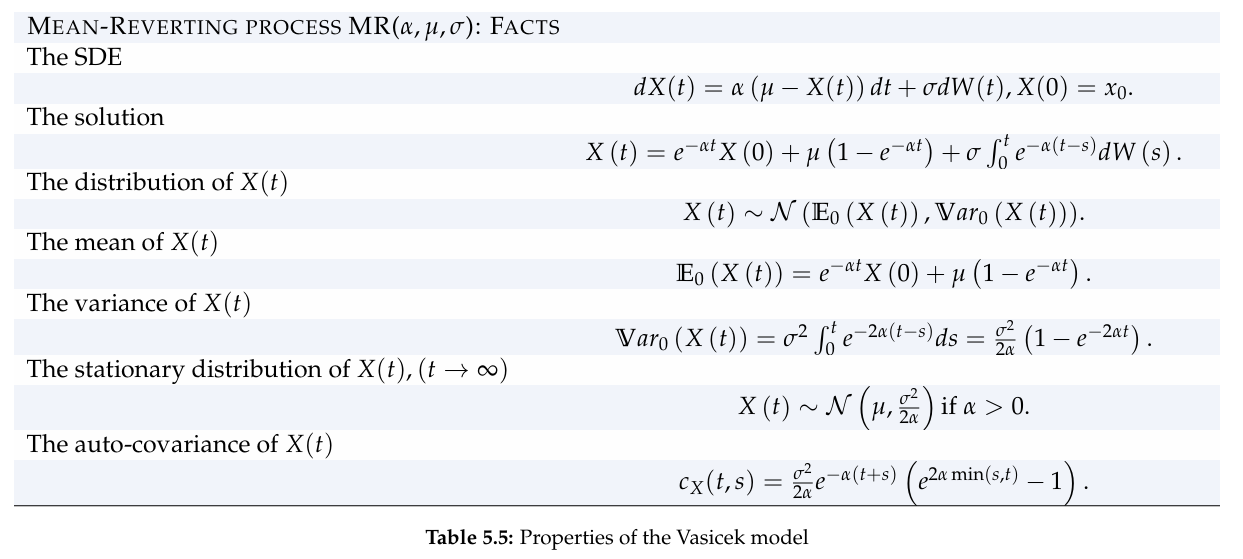


In [13]:
# OUP
# Setting Parameters =======================================================================================
N_SIMS = 20000  # FIXME: number of simulations
N_STEPS = 200   # FIXME: number of steps (excluding t = 0)
ALPHA = 5       # FIXME: mean reversion speed
SIGMA = 0.07    # FIXME: volatility
MU = 0.07       # FIXME: long-term mean
X0 = 0.03       # FIXME: initial value
T = 1           # FIXME: time horizon

dt = T / N_STEPS
t_steps = np.linspace(0, T, N_STEPS + 1)

# SIMULATION ===============================================================================================
X = np.vstack([np.full(N_SIMS, X0), np.zeros((N_STEPS, N_SIMS))]) # Each row is a time step, each column is a simulation
Y = X.copy()
# Z = rnorm(N_SIMS * N_STEPS).reshape((N_STEPS, N_SIMS))
Z = np.random.normal(size = (N_STEPS, N_SIMS))

# Euler-Maruyama with Analytical Moments
for i in range(N_STEPS):
    X[i + 1] = MU + (X[i] - MU) * np.exp(-ALPHA * dt) + SIGMA * np.sqrt((1 - np.exp(-2 * ALPHA * dt)) / (2 * ALPHA)) * Z[i]

# Plan Euler-Maruyama
for i in range(N_STEPS):
    Y[i + 1] = Y[i] + ALPHA * (MU - Y[i]) * dt + SIGMA * np.sqrt(dt) * Z[i]

# Computing Statistics =====================================================================================
def mean_ou(x0, t, mu, alpha): # Theoretical mean of OU process
    return np.exp(-alpha * t) * x0 + mu * (1 - np.exp(-alpha * t))

def var_ou(x0, t, mu, alpha, sigma): # Theoretical variance of OU process
    return sigma**2 / (2 * alpha) * (1 - np.exp(-2 * alpha * t))

t_steps = np.linspace(0, T, N_STEPS + 1)
sample_mean = X.mean(axis = 1)
sample_var = X.var(axis = 1)
exact_mean = mean_ou(X0, t_steps, MU, ALPHA)
exact_var = var_ou(X0, t_steps, MU, ALPHA, SIGMA)


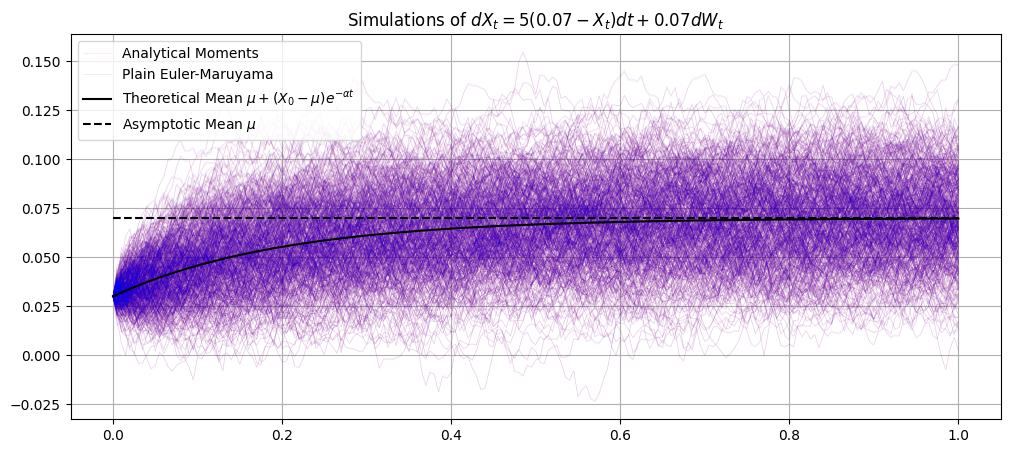

trajectories plotted
plotting variance


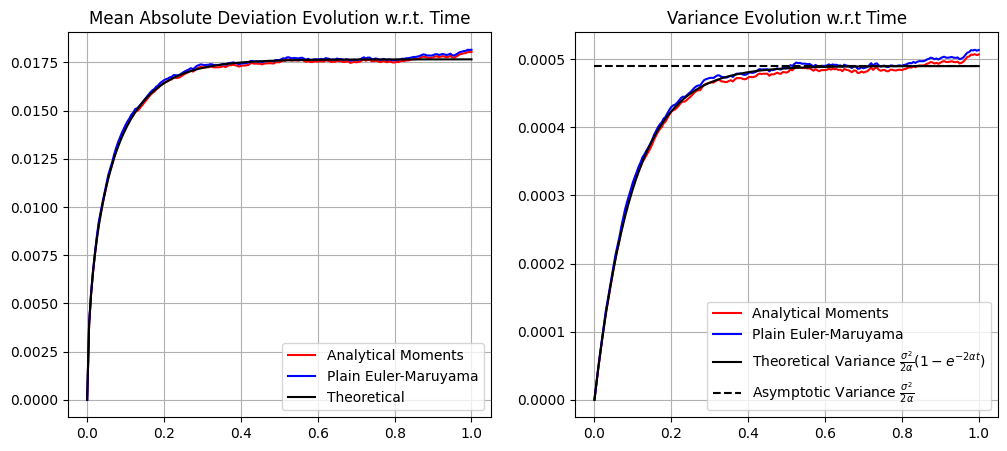

In [17]:
# PLOT =====================================================================================================

# Plotting trajectories ---------------------------------------------------------------
plt.figure(figsize = (12, 5), clear = True)

plt.title(f"Simulations of $dX_t = {ALPHA}({MU}-X_t)dt+{SIGMA}dW_t$")
plt.plot(t_steps, X[:,:500], color = "red", alpha = 0.1, lw = 0.5, label = "Analytical Moments")
plt.plot(t_steps, Y[:,:500], color = "blue", alpha = 0.1, lw = 0.5, label = "Plain Euler-Maruyama")
plt.plot(t_steps, MU + (X0 - MU) * np.exp(-ALPHA * t_steps), color = "black", label = r"Theoretical Mean $\mu+(X_0-\mu)e^{-\alpha t}$")
plt.plot(t_steps, np.full(N_STEPS + 1, MU), color = "black", linestyle = "--", label = r"Asymptotic Mean $\mu$")

# Only show one legend for all simulations
handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()

plt.show()

print("trajectories plotted")

# Plotting MAD and Variance --------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

ax[0].set_title("Mean Absolute Deviation Evolution w.r.t. Time")

# Sample Mean Absolute Deviation from Theoretical Mean
ax[0].plot(t_steps, np.mean(np.abs(X - exact_mean.reshape((N_STEPS + 1, 1))), axis = 1), color = "red", label = "Analytical Moments")
ax[0].plot(t_steps, np.mean(np.abs(Y - exact_mean.reshape((N_STEPS + 1, 1))), axis = 1), color = "blue", label = "Plain Euler-Maruyama")

# Theoretical Mean Absolute Deviation
ax[0].plot(t_steps, SIGMA * np.sqrt((1 - np.exp(-2 * ALPHA * t_steps)) / (ALPHA * np.pi)), color = "black", label = "Theoretical")

ax[0].grid()
ax[0].legend()

ax[1].set_title("Variance Evolution w.r.t Time")

print("plotting variance")

# Sample variance
ax[1].plot(t_steps, X.var(axis = 1), color = "red", label = "Analytical Moments")
ax[1].plot(t_steps, Y.var(axis = 1), color = "blue", label = "Plain Euler-Maruyama")

# Theoretical and Asymptotic Variance
ax[1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance $\frac{\sigma^2}{2\alpha}(1-e^{-2\alpha t})$")
ax[1].plot(t_steps, np.full(N_STEPS + 1, SIGMA**2 / (2 * ALPHA)), color = "black", linestyle = "--", label = r"Asymptotic Variance $\frac{\sigma^2}{2\alpha}$")

ax[1].grid()
ax[1].legend()

plt.show()

# Histogram from OU slices & Theoretical Normal Distribution ----------------------------------------------



# Autocorrelation can take a value as high as the variance
# Correlation is only between -1 and 1

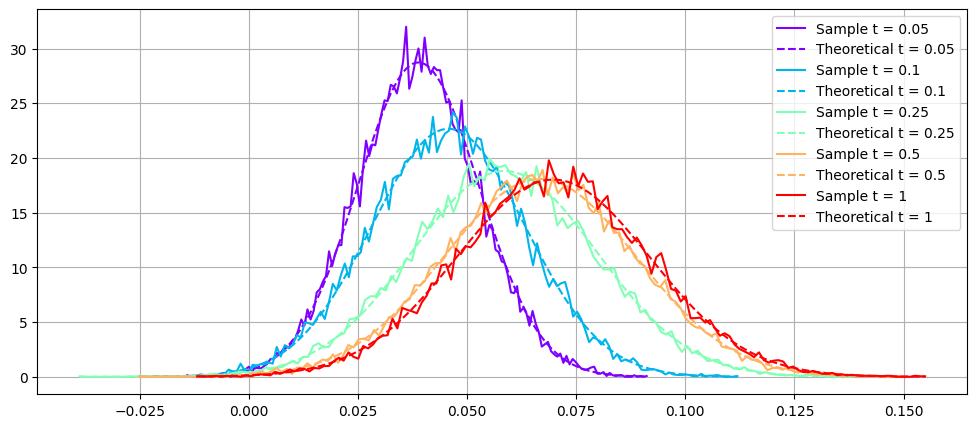

In [ ]:
plt.figure(figsize = (12, 5), clear = True)

time_slices = [0.05, 0.1, 0.25, 0.5, 1]

# Use color map to generate colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(time_slices)))

for i, time in enumerate(time_slices):
    # Genearte density information
    p, x = np.histogram(X[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Plotting
    plt.plot(x, p, color = colors[i], label = f"Sample t = {time}")
    plt.plot(x, stats.norm.pdf(x, loc = mean_ou(X0, time, MU, ALPHA), scale = np.sqrt(var_ou(X0, time, MU, ALPHA, SIGMA))), "--", color = colors[i] , label = f"Theoretical t = {time}")

plt.legend()
plt.grid()
plt.show()

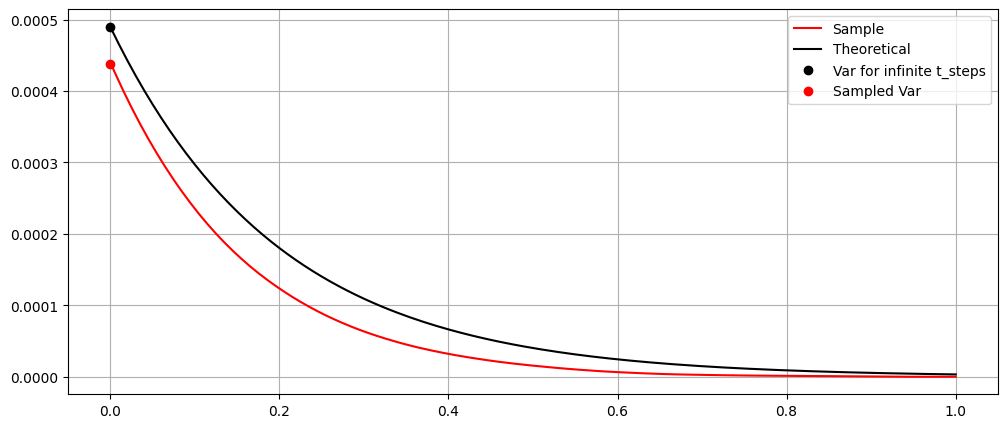

In [34]:
plt.figure(figsize = (12, 5), clear = True)

# Compute autocovariance
C = np.zeros((N_STEPS * 2 + 1, N_SIMS))
for i in range(N_SIMS):
    C[:, i] = np.correlate(X[:, i] - exact_mean, X[:, i] - exact_mean, mode = "full") / N_STEPS
C = C[N_STEPS:].mean(axis = 1)

plt.plot(t_steps, C, color = "red", label = "Sample")
plt.plot(t_steps, SIGMA**2 / (2*ALPHA) * np.exp(-ALPHA * t_steps), color = "black", label = "Theoretical")

plt.plot(0, SIGMA**2 / (2 * ALPHA), 'o', color = "black", label = 'Var for infinite t_steps')
plt.plot(0, np.mean(np.var(X, axis=1)), 'o', color = "red", label = 'Sampled Var')

plt.legend()
plt.grid()
plt.show()

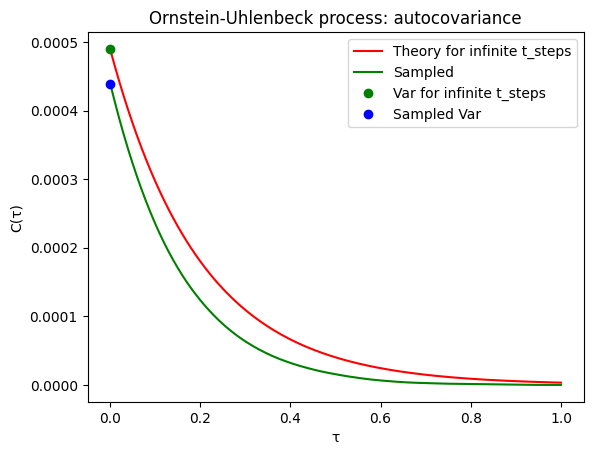

In [19]:
# Compute auto-correlation

plt.figure(figsize = (12, 5), clear = True)



plt.show()

---

#### Cox-Ingersoll-Ross Model

$$
dX_t = \alpha(\mu-X_t)dt + \sigma\sqrt{X_t}dW_t
$$

array([ 3,  8, 14,  8,  3])